## Environment setting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/keras-video-classification

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/keras-video-classification


In [2]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (97.3 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [3]:
!tree --dirsfirst --filelimit 50

.
├── example_clips
│   ├── lifting.mp4
│   ├── soccer.mp4
│   └── tennis.mp4
├── model
│   ├── activity.model
│   └── lb.pickle
├── output
│   └── lifting_128.avi
└── Sports-Type-Classifier
    └── data
        ├── football [91 entries exceeds filelimit, not opening dir]
        ├── tennis [92 entries exceeds filelimit, not opening dir]
        └── weight_lifting [96 entries exceeds filelimit, not opening dir]

8 directories, 6 files


In [4]:
!ls Sports-Type-Classifier/data | grep -Ev "urls|models|csv|pkl" 

football
tennis
weight_lifting


In [4]:
!tree --dirsfirst --filelimit 50

.
├── example_clips
│   ├── lifting.mp4
│   ├── soccer.mp4
│   └── tennis.mp4
├── model
│   ├── activity.model
│   └── lb.pickle
├── output
│   └── lifting_128.avi
├── Sports-Type-Classifier
│   └── data
│       ├── football [91 entries exceeds filelimit, not opening dir]
│       ├── tennis [92 entries exceeds filelimit, not opening dir]
│       └── weight_lifting [96 entries exceeds filelimit, not opening dir]
├── Sports-Type-Classifier-master
│   ├── data
│   │   ├── badminton [938 entries exceeds filelimit, not opening dir]
│   │   ├── baseball [746 entries exceeds filelimit, not opening dir]
│   │   ├── basketball [495 entries exceeds filelimit, not opening dir]
│   │   ├── boxing [705 entries exceeds filelimit, not opening dir]
│   │   ├── chess [481 entries exceeds filelimit, not opening dir]
│   │   ├── cricket [715 entries exceeds filelimit, not opening dir]
│   │   ├── fencing [635 entries exceeds filelimit, not opening dir]
│   │   ├── football [799 entries exceeds filelimit,

### Import the packages



In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import LabelBinarizer #one-hot enocding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

# set the matplotlib backend to make output file of model training
import matplotlib
matplotlib.use("Agg")

## Load dataset

In [6]:
args = { "dataset" : "/content/drive/My Drive/keras-video-classification/Sports-Type-Classifier/data",
        "model" : "/content/drive/My Drive/keras-video-classification/model/activity.model",
				"label_bin" : "/content/drive/My Drive/keras-video-classification/model/lb.pickle" ,
        "epochs" : 50,
        "plot" : "plot.png"}

In [7]:
print(args)

{'dataset': '/content/drive/My Drive/keras-video-classification/Sports-Type-Classifier/data', 'model': '/content/drive/My Drive/keras-video-classification/model/activity.model', 'label_bin': '/content/drive/My Drive/keras-video-classification/model/lb.pickle', 'epochs': 50, 'plot': 'plot.png'}


In [8]:
# initialize the set of labels from the dataset
LABELS = set(["weight_lifting", "tennis", "football"])

# grab the list of images in our dataset directory, then initialize the list of data and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
print(imagePaths[:2])

data = []
labels = []

[INFO] loading images...
['/content/drive/My Drive/keras-video-classification/Sports-Type-Classifier/data/football/00000053.jpg', '/content/drive/My Drive/keras-video-classification/Sports-Type-Classifier/data/football/00000007.jpg']


In [9]:
# loop over the image paths
for imagePath in imagePaths:

	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# if the label of the current image is not part of of the labels 
  # which are interested in, then ignore the image
	if label not in LABELS:
		continue

	# load the image, convert it to RGB channel ordering, and resize it 
  # to be a fixed 224x224 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

  # update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

print(image.shape)

(224, 224, 3)


In [10]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [11]:
print(labels[0])
print(labels[100])
print(labels[-1])

[1 0 0]
[0 1 0]
[0 0 1]





## Model training



In [12]:
# partition the data into training and testing splits
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, 
                                                  stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=30, 
                              zoom_range=0.15,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.15,
                              horizontal_flip=True,
                              fill_mode="nearest")

# for Validation
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order)
mean = np.array([123.68, 116.779, 103.939], dtype="float32")

# set the mean attribute for trainAug and valAug 
trainAug.mean = mean
valAug.mean = mean


### Model : ResNet-50

In [13]:
# load the ResNet-50 network pre-trained with ImageNet weights while chopping the head of the network off, 
# ensuring the head FC layer sets are left off
baseModel = ResNet50(weights="imagenet", include_top=False, 
                     input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
# assemble a new 'headModel' and suture it onto the 'baseModel'
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)


# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the 'baseModel' and freeze them so that 
# it will not be trained via backpropagation
# they will *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / args["epochs"]) 
# Stochastic Gradient Descent (SGD)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


94773248/94765736 [==============================] - 1s 0us/step
[INFO] compiling model...


In [20]:
baseModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [14]:
# train only the head of the network for a few epochs 
# (all other layers in the 'baseModel' are frozen) 
# -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(x=trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=args["epochs"])

[INFO] training head...
Epoch 1/50
6/6 [==============================] - 3s 443ms/step - loss: 1.9579 - accuracy: 0.3410 - val_loss: 1.5157 - val_accuracy: 0.3125
Epoch 2/50
6/6 [==============================] - 2s 310ms/step - loss: 1.7179 - accuracy: 0.3237 - val_loss: 1.1226 - val_accuracy: 0.3906
Epoch 3/50
6/6 [==============================] - 2s 314ms/step - loss: 1.4857 - accuracy: 0.4104 - val_loss: 0.9323 - val_accuracy: 0.5469
Epoch 4/50
6/6 [==============================] - 2s 308ms/step - loss: 1.4256 - accuracy: 0.4220 - val_loss: 0.8301 - val_accuracy: 0.6406
Epoch 5/50
6/6 [==============================] - 2s 308ms/step - loss: 1.1042 - accuracy: 0.4913 - val_loss: 0.7381 - val_accuracy: 0.6875
Epoch 6/50
6/6 [==============================] - 2s 320ms/step - loss: 1.0503 - accuracy: 0.5491 - val_loss: 0.6606 - val_accuracy: 0.7656
Epoch 7/50
6/6 [==============================] - 2s 348ms/step - loss: 1.0267 - accuracy: 0.5417 - val_loss: 0.5706 - val_accuracy: 0.8

In [15]:
# evaluate the network on the testing set
print("[INFO] evaluating network...")
predictions = model.predict(x=testX.astype("float32"), batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
                precision    recall  f1-score   support

      football       0.96      1.00      0.98        22
        tennis       1.00      0.96      0.98        23
weight_lifting       1.00      1.00      1.00        24

      accuracy                           0.99        69
     macro avg       0.99      0.99      0.99        69
  weighted avg       0.99      0.99      0.99        69



In [20]:
# plot the training loss and accuracy
N = args["epochs"]
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

In [21]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save(args["model"], save_format="h5")

# serialize the label binarizer to disk
f = open(args["label_bin"], "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network...


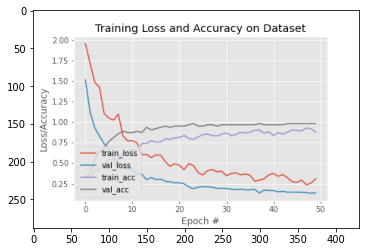

In [7]:
result = plt.imread('./plot.png')
plt.imshow(result)
plt.show()

## Model test : Video Classification

In [ ]:
!ls model

activity.model	lb.pickle


In [ ]:
from tensorflow.keras.models import load_model
from collections import deque #for the rolling average algorithm
import numpy as np
import argparse
import pickle
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
args = { "dataset" : "/content/drive/My Drive/keras-video-classification/Sports-Type-Classifier/data",
        "model" : "/content/drive/My Drive/keras-video-classification/model/activity.model",
				"label_bin" : "/content/drive/My Drive/keras-video-classification/model/lb.pickle" ,
        "input" : "/content/drive/My Drive/keras-video-classification/example_clips/lifting.mp4",
        "output" : "/content/drive/My Drive/keras-video-classification/output/lifting_result.mp4",
        "size" : 128}

In [ ]:
# load the trained model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model(args["model"])
lb = pickle.loads(open(args["label_bin"], "rb").read())


[INFO] loading model and label binarizer...


In [ ]:
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=args["size"])

In [ ]:
# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(args["input"])
writer = None
(W, H) = (None, None)

# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# clone the output frame, then convert it from BGR to RGB
	# ordering, resize the frame to a fixed 224x224, and then
	# perform mean subtraction
	output = frame.copy()
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	frame = cv2.resize(frame, (224, 224)).astype("float32")
	frame -= mean

  
  # Rolling prediction averaging
	# make predictions on the frame and then update the predictions queue
	preds = model.predict(np.expand_dims(frame, axis=0))[0]
	Q.append(preds)

	# perform prediction averaging over the current history of previous predictions
	results = np.array(Q).mean(axis=0)
	i = np.argmax(results)
	label = lb.classes_[i]

	# draw the activity on the output frame
	text = "activity: {}".format(label)
	cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)

	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 30, (W, H), True)

	# write the output frame to disk
	writer.write(output)

	# show the output image
	cv2_imshow(output)
	key = cv2.waitKey(1) & 0xFF
  
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

In [7]:
def show_viedo_result(file_name, ext='mp4'):
  from IPython.display import HTML
  from base64 import b64encode

  video_result = open(filename + '.' + ext,'rb').read()
  data_url = 'data:video/mp4;base64,' + b64encode(video_result).decode()

  HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)


In [5]:
!ffmpeg -i './output/lifting_128.avi' lift.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib